In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path  # For defining dataset Paths
import sys                # For include librep package
sys.path.append("../../..")

# Third party imports
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.metrics.report import ClassificationReport
from librep.estimators import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from librep.metrics.dimred_evaluator import DimensionalityReductionQualityReport

from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder


from librep.transforms import UMAP
from tabulate import tabulate

2022-10-22 18:07:30.882726: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-22 18:07:30.882747: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
from Experiments_topoae_KuHar20Hz_helper import *
kuhar_data = obtainKuHar20Hz()
train_HD = kuhar_data['train_HD']
train_LD = kuhar_data['train_LD']
train_Y = kuhar_data['train_Y']
test_HD = kuhar_data['test_HD']
test_LD = kuhar_data['test_LD']
test_Y = kuhar_data['test_Y']

# Preparing Table

Columns:
* RF (Accuracy, F1)
* SVC (Accuracy, F1)
* KNN (Accuracy, F1)
* Trustworthiness
* Continuity
* Co-k-nearest-neighbor-size

Rows:
* UMAP (2 dim)
* Generic Autoencoders
* Topological autoencoders (L=1)
* Topological autoencoders (L=100)

In [5]:
def print_table(table_info):
    tabulated = tabulate(
        table_info,
        headers='keys',
        tablefmt='fancy_grid',
        missingval='-'
    )
    print(tabulated)


table_info = {
    'Metrics': ['RF-ACC', 'RF-F1',
                'SVC-ACC', 'SVC-F1',
                'KNN-ACC', 'KNN-F1',
                'Trustworthiness',
                'Continuity',
                'Co-k-NNs'],
    'UMAP': ['-']*9,
    'Generic-AE': ['-']*9,
    'Topo-AEv2 (L=1000)': ['-']*9,
    'Topo-AEv2 (L=10000)': ['-']*9,
    'M-AE (L=1000)': ['-']*9,
    'M-AE (L=10000)': ['-']*9
}
print_table(table_info)

╒═════════════════╤════════╤══════════════╤══════════════════════╤═══════════════════════╤═════════════════╤══════════════════╕
│ Metrics         │ UMAP   │ Generic-AE   │ Topo-AEv2 (L=1000)   │ Topo-AEv2 (L=10000)   │ M-AE (L=1000)   │ M-AE (L=10000)   │
╞═════════════════╪════════╪══════════════╪══════════════════════╪═══════════════════════╪═════════════════╪══════════════════╡
│ RF-ACC          │ -      │ -            │ -                    │ -                     │ -               │ -                │
├─────────────────┼────────┼──────────────┼──────────────────────┼───────────────────────┼─────────────────┼──────────────────┤
│ RF-F1           │ -      │ -            │ -                    │ -                     │ -               │ -                │
├─────────────────┼────────┼──────────────┼──────────────────────┼───────────────────────┼─────────────────┼──────────────────┤
│ SVC-ACC         │ -      │ -            │ -                    │ -                     │ -            

# Visualization helper

In [6]:
def visualize(X, Y, filtered=None, xlim=None, ylim=None):
    data_grouped = list(zip(X, Y))
    uniques = filtered
    if filtered is None:
        uniques = np.unique(Y)
    
    for uval in uniques:
        data = [pair[0] for pair in data_grouped if pair[1]==uval]
        data_x = [unit[0] for unit in data]
        data_y = [unit[1] for unit in data]
        plt.scatter(data_x, data_y, label = uval)
    # print(data)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.grid()
    plt.legend()
    plt.show()

# Applying Scaler

MinMaxScaler, MaxAbsScaler and StandardScaler apply the scaling PER FEATURE, which means the distance between points would actually be modified, and so, the ranking as well.
Because of this, a new Scaler is used

In [7]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.fftpack

# # Number of samplepoints
# N = 600
# # sample spacing
# T = 1.0 / 800.0
# x = np.linspace(0.0, N*T, N)
# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
# yf = scipy.fftpack.fft(y)
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


# # print(x)
# # print(xf)

# fig, ax = plt.subplots()
# # ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# ax.plot(x,y)
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# # ax.plot(x,y)
# plt.show()


In [8]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.fftpack

# # Number of samplepoints
# N = 600
# # sample spacing
# T = 1.0 / 800.0
# x = np.linspace(0.0, N*T, N)
# y = 2*(np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x))
# yf = scipy.fftpack.fft(y)
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


# # print(x)
# # print(xf)

# fig, ax = plt.subplots()
# # ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# ax.plot(x,y)
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# # ax.plot(x,y)
# plt.show()


In [9]:
# from sklearn import preprocessing

# scaler = preprocessing.MinMaxScaler()

In [10]:
# train_HD = scaler.fit_transform(train_dataset_fft.X)
# train_LD = None
# # train_Y = train_dataset_fft.y
# test_HD = scaler.fit_transform(test_dataset_fft.X)
# test_LD = None
# # test_Y = test_dataset_fft.y

## Set Reporter

In [11]:
reporter = ClassificationReport(
    use_accuracy=True, 
    use_f1_score=True,
    use_classification_report=False,
    use_confusion_matrix=False,
    plot_confusion_matrix=False
)

# **SECTION:** Exploring Topological AE (lambdas)

In [12]:
lambdas_to_explore = [1, 10, 100, 1000, 5000, 10000]
executions_per_model = 10

def explore_lambda(train_HD, train_Y, test_HD, test_Y, topoae_lambda, times_to_execute=10):
    result_object = {
        'RF-ACC': [],
        'RF-F1': [],
        'SVC-ACC': [],
        'SVC-F1': [],
        'KNN-ACC': [],
        'KNN-F1': [],
        'Trustworthiness': [],
        'Continuity': [],
        'Co-k-NNs': []   
    }
    for _ in range(times_to_execute):
        kwargs = {'input_dims':180, 'custom_dim':2}
        input_shape = (-1, 1, 180)
        topo_reducer = TopologicalDimensionalityReduction(
            ae_model='DeepAEforKuhar180ver2',
            lam=topoae_lambda,
            ae_kwargs=kwargs,
            input_shape=input_shape,
            patience=10
        )
        title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
        topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)
        train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
        test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
        experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
        metrics_reporter = DimensionalityReductionQualityReport()
        metrics_report = metrics_reporter.evaluate([test_HD, test_LD])
        
        result_object['RF-ACC'] = experiments_result['RF-ACC']
        result_object['RF-F1'] = experiments_result['RF-F1']
        result_object['SVC-ACC'] = experiments_result['SVC-ACC']
        result_object['SVC-F1'] = experiments_result['SVC-F1']
        result_object['KNN-ACC'] = experiments_result['KNN-ACC']
        result_object['KNN-F1'] = experiments_result['KNN-F1']
        
        result_object['Trustworthiness'] = metrics_report['trustworthiness']
        result_object['Continuity'] = metrics_report['continuity']
        result_object['Co-k-NNs'] = metrics_report['co k nearest neighbor size']
        
    for obj_property in result_object:
        mean_val = np.mean(result_object[obj_property])
        min_val = np.min(result_object[obj_property])
        max_val = np.max(result_object[obj_property])
        result_object[obj_property] = (min_val, mean_val, max_val)

    return result_object


Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:368.2400, Loss-ae:340.1227, Loss-topo:28.1174
Epoch:2, P:10, Loss:323.6102, Loss-ae:295.0351, Loss-topo:28.5751
Epoch:3, P:10, Loss:328.5713, Loss-ae:318.5667, Loss-topo:10.0046
Epoch:4, P:9, Loss:297.6847, Loss-ae:288.3696, Loss-topo:9.3151
Epoch:5, P:10, Loss:255.0571, Loss-ae:253.4802, Loss-topo:1.5769
Epoch:6, P:10, Loss:262.7224, Loss-ae:259.6642, Loss-topo:3.0582
Epoch:7, P:9, Loss:224.7318, Loss-ae:223.4496, Loss-topo:1.2823
Epoch:8, P:10, Loss:233.6530, Loss-ae:231.8678, Loss-topo:1.7852
Epoch:9, P:9, Loss:185.3714, Loss-ae:182.2283, Loss-topo:3.1431
Epoch:10, P:10, Loss:197.6258, Loss-ae:192.3564, Loss-topo:5.2694
Epoch:11, P:9, Loss:209.7654, Loss-ae:204.0142, Loss-topo:5.7511
Epoch:12, P:8, Loss:194.3997, Loss-ae:190.0353, Loss-topo:4.3644
Epoch:13, P:7, Loss:203.8396, Loss-ae:199.2674, Loss-topo:4.5722
Epoch:14, P:6, Loss:173.

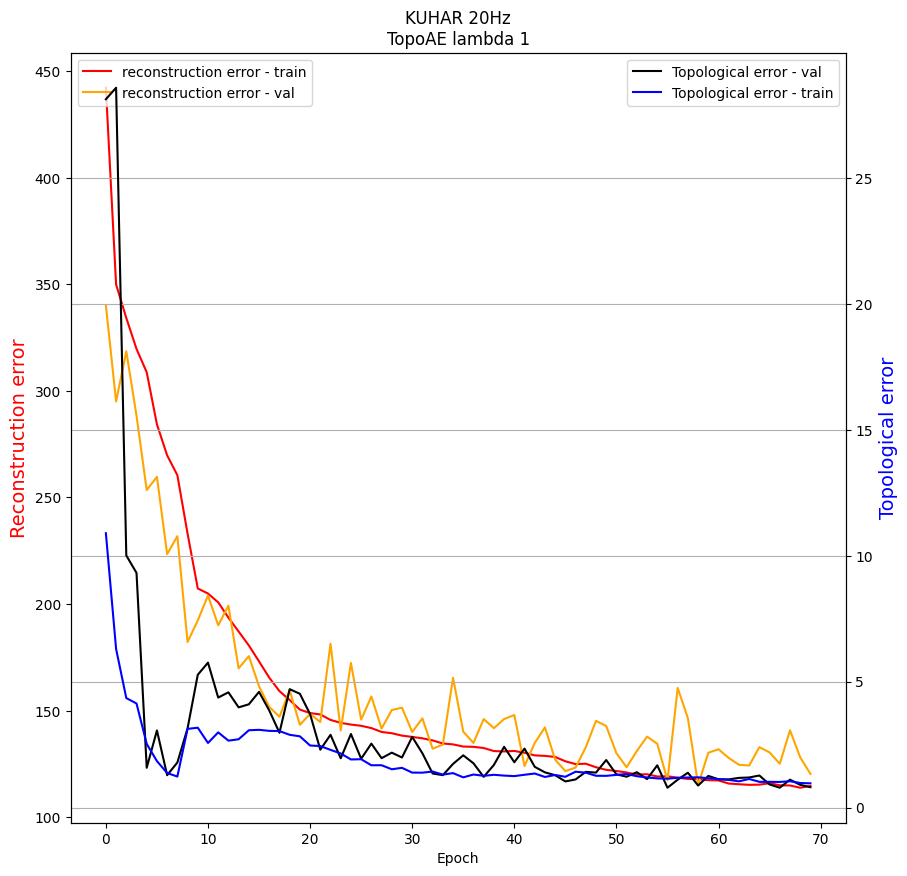

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:374.3354, Loss-ae:362.7923, Loss-topo:11.5431
Epoch:2, P:10, Loss:276.6139, Loss-ae:264.0981, Loss-topo:12.5158
Epoch:3, P:10, Loss:289.3651, Loss-ae:279.4210, Loss-topo:9.9441
Epoch:4, P:9, Loss:258.1425, Loss-ae:254.8511, Loss-topo:3.2915
Epoch:5, P:10, Loss:240.3192, Loss-ae:238.1091, Loss-topo:2.2101
Epoch:6, P:10, Loss:241.4262, Loss-ae:235.9825, Loss-topo:5.4438
Epoch:7, P:9, Loss:235.8290, Loss-ae:234.8256, Loss-topo:1.0034
Epoch:8, P:10, Loss:247.9406, Loss-ae:243.4165, Loss-topo:4.5241
Epoch:9, P:9, Loss:229.6897, Loss-ae:227.3616, Loss-topo:2.3282
Epoch:10, P:10, Loss:214.7164, Loss-ae:208.6582, Loss-topo:6.0582
Epoch:11, P:10, Loss:190.9038, Loss-ae:186.8234, Loss-topo:4.0804
Epoch:12, P:10, Loss:192.1725, Loss-ae:186.6626, Loss-topo:5.5099
Epoch:13, P:9, Loss:175.9692, Loss-ae:172.3523, Loss-topo:3.6169
Epoch:14, P:10, Loss:15

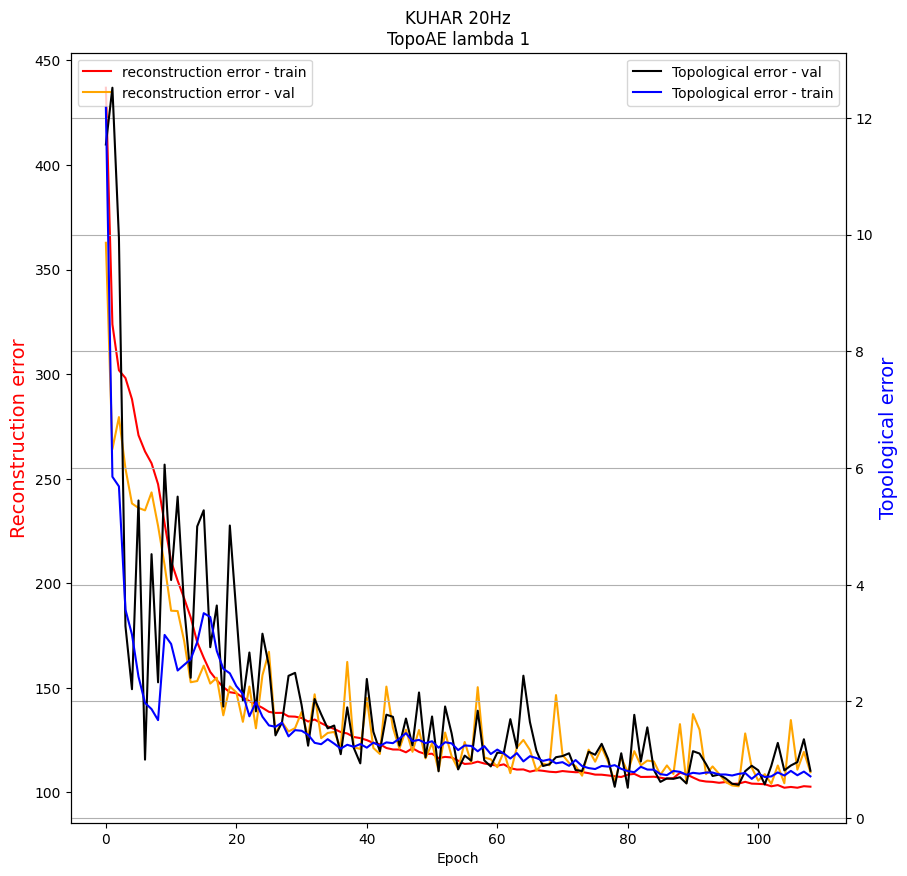

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:335.8165, Loss-ae:328.1830, Loss-topo:7.6335
Epoch:2, P:10, Loss:296.0182, Loss-ae:278.3287, Loss-topo:17.6895
Epoch:3, P:10, Loss:270.2679, Loss-ae:264.0547, Loss-topo:6.2132
Epoch:4, P:10, Loss:256.5753, Loss-ae:254.2210, Loss-topo:2.3543
Epoch:5, P:10, Loss:324.0980, Loss-ae:316.8153, Loss-topo:7.2827
Epoch:6, P:9, Loss:237.2011, Loss-ae:236.0317, Loss-topo:1.1694
Epoch:7, P:10, Loss:248.9047, Loss-ae:243.6718, Loss-topo:5.2329
Epoch:8, P:9, Loss:242.9038, Loss-ae:237.4896, Loss-topo:5.4143
Epoch:9, P:8, Loss:231.1885, Loss-ae:224.9304, Loss-topo:6.2581
Epoch:10, P:10, Loss:199.4084, Loss-ae:195.8445, Loss-topo:3.5639
Epoch:11, P:10, Loss:213.2636, Loss-ae:207.1506, Loss-topo:6.1130
Epoch:12, P:9, Loss:187.3693, Loss-ae:180.8643, Loss-topo:6.5049
Epoch:13, P:10, Loss:176.8055, Loss-ae:171.4923, Loss-topo:5.3131
Epoch:14, P:10, Loss:194

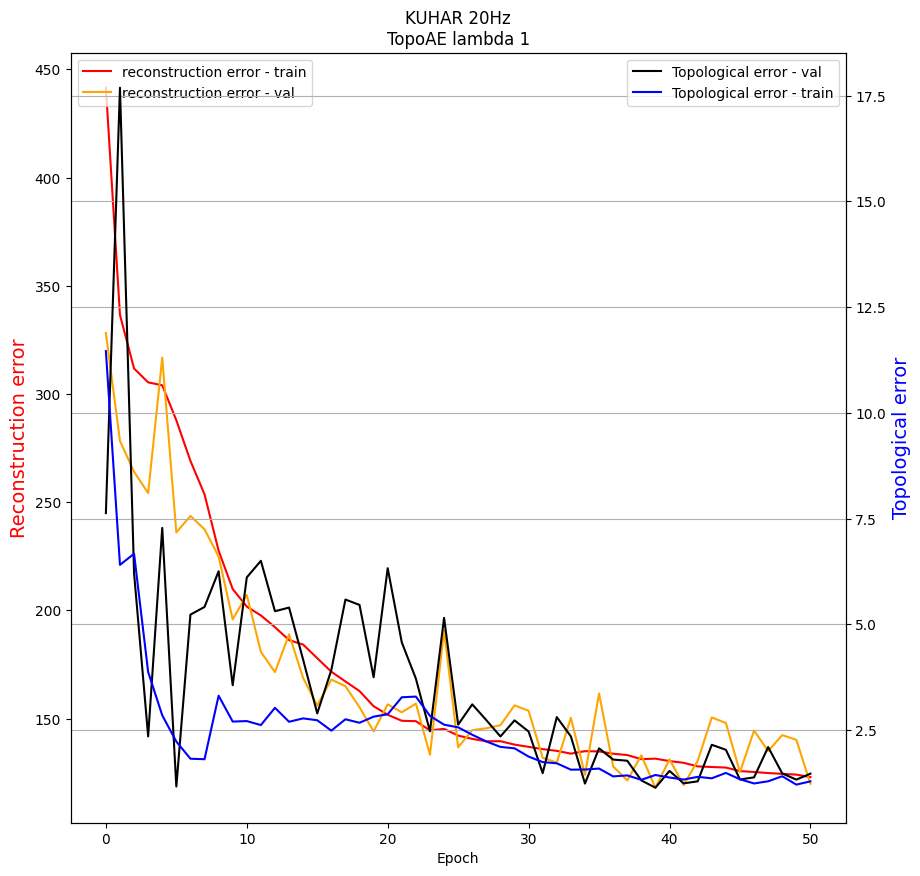

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:318.9776, Loss-ae:300.9722, Loss-topo:18.0054
Epoch:2, P:10, Loss:284.7545, Loss-ae:274.5150, Loss-topo:10.2395
Epoch:3, P:10, Loss:289.7646, Loss-ae:282.8651, Loss-topo:6.8994
Epoch:4, P:9, Loss:281.2578, Loss-ae:277.3172, Loss-topo:3.9406
Epoch:5, P:10, Loss:314.5533, Loss-ae:311.0051, Loss-topo:3.5482
Epoch:6, P:9, Loss:250.6653, Loss-ae:249.3953, Loss-topo:1.2700
Epoch:7, P:10, Loss:305.8382, Loss-ae:302.6844, Loss-topo:3.1538
Epoch:8, P:9, Loss:219.3259, Loss-ae:217.5430, Loss-topo:1.7829
Epoch:9, P:10, Loss:202.9931, Loss-ae:199.9305, Loss-topo:3.0627
Epoch:10, P:10, Loss:203.6802, Loss-ae:198.6467, Loss-topo:5.0334
Epoch:11, P:9, Loss:203.4429, Loss-ae:199.8279, Loss-topo:3.6150
Epoch:12, P:8, Loss:185.5570, Loss-ae:182.6529, Loss-topo:2.9041
Epoch:13, P:10, Loss:176.6614, Loss-ae:174.6208, Loss-topo:2.0407
Epoch:14, P:10, Loss:183

KeyboardInterrupt: 

In [13]:
plot_object = {
    'RF-ACC': [],
    'RF-F1': [],
    'SVC-ACC': [],
    'SVC-F1': [],
    'KNN-ACC': [],
    'KNN-F1': [],
    'Trustworthiness': [],
    'Continuity': [],
    'Co-k-NNs': []   
}

for lambda_val in lambdas_to_explore:
    lambda_exploration = explore_lambda(train_HD, train_Y, test_HD, test_Y, lambda_val)
    # print(lambda_val, lambda_exploration)
    for obj_property in plot_object:
        plot_object[obj_property].append(lambda_exploration[obj_property])
    
# print(plot_object)

In [ ]:
print(plot_object)

In [ ]:
data_x = range(len(lambdas_to_explore))
plt.xticks(data_x, [str(val) for val in lambdas_to_explore])
for obj_property in plot_object:
    data_y = [val[1] for val in plot_object[obj_property]]
    plt.plot(data_x, data_y, label=obj_property)

ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Metrics values over lambdas\nKuHar20Hz TopoAE-2dim')
plt.xlabel('Lambda value')
plt.ylabel('Metric value')
plt.grid()
plt.ylim((0, 1))
plt.show()


In [ ]:
assert 1 ==0
asda = {'asd': [2, 3], 'asdasd': [3,4,5]}
for i in asda:
    asda[i] = np.mean(asda[i])
print(asda)

In [ ]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
topoae_lambda = 10000
topo_reducer = TopologicalDimensionalityReduction(ae_model='DeepAEforKuhar180ver2', lam=topoae_lambda,
                                                      ae_kwargs=kwargs, input_shape=input_shape, patience=10)

In [ ]:
title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

## Obtain classification metrics (RF, SVC, KNN)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
table_info['Topo-AEv2 (L=10000)'][0] = experiments_result['RF-ACC']
table_info['Topo-AEv2 (L=10000)'][1] = experiments_result['RF-F1']
table_info['Topo-AEv2 (L=10000)'][2] = experiments_result['SVC-ACC']
table_info['Topo-AEv2 (L=10000)'][3] = experiments_result['SVC-F1']
table_info['Topo-AEv2 (L=10000)'][4] = experiments_result['KNN-ACC']
table_info['Topo-AEv2 (L=10000)'][5] = experiments_result['KNN-F1']

print_table(table_info)

## Obtain quality metrics

In [ ]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [ ]:
metrics_report

In [ ]:
table_info['Topo-AEv2 (L=10000)'][6] = metrics_report['trustworthiness']
table_info['Topo-AEv2 (L=10000)'][7] = metrics_report['continuity']
table_info['Topo-AEv2 (L=10000)'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

## Visualization

In [ ]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
# for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    # visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** UMAP

In [ ]:
umap_reducer = UMAP()
umap_reducer.fit(train_HD, train_Y)

In [ ]:
train_LD = np.reshape(umap_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(umap_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

## Obtain classification metrics (RF, SVC, KNN)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
table_info['UMAP'][0] = experiments_result['RF-ACC']
table_info['UMAP'][1] = experiments_result['RF-F1']
table_info['UMAP'][2] = experiments_result['SVC-ACC']
table_info['UMAP'][3] = experiments_result['SVC-F1']
table_info['UMAP'][4] = experiments_result['KNN-ACC']
table_info['UMAP'][5] = experiments_result['KNN-F1']

print_table(table_info)

## Obtain quality metrics

In [ ]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [ ]:
metrics_report

In [ ]:
table_info['UMAP'][6] = metrics_report['trustworthiness']
table_info['UMAP'][7] = metrics_report['continuity']
table_info['UMAP'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

## Visualization

In [ ]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
# for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    # visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** Metrics AE (metric=coknns, lambda=1000)

In [ ]:
from librep.transforms.adapted_ae import AdaptedAEDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import MetricsRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
mae_lambda = 1000
mae_reducer = AdaptedAEDimensionalityReduction(
    ae_model='DeepAEforKuhar180ver2',
    lam=mae_lambda,
    metric='coknns',
    ae_kwargs=kwargs,
    input_shape=input_shape,
    patience=10
)

In [ ]:
title_plot = "KUHAR 20Hz\nAdaptedAE lambda " + str(mae_lambda)
mae_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
train_LD = np.reshape(mae_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(mae_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

## Obtain classification metrics (RF, SVC, KNN)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
table_info['M-AE (L=1000)'][0] = experiments_result['RF-ACC']
table_info['M-AE (L=1000)'][1] = experiments_result['RF-F1']
table_info['M-AE (L=1000)'][2] = experiments_result['SVC-ACC']
table_info['M-AE (L=1000)'][3] = experiments_result['SVC-F1']
table_info['M-AE (L=1000)'][4] = experiments_result['KNN-ACC']
table_info['M-AE (L=1000)'][5] = experiments_result['KNN-F1']

print_table(table_info)

## Obtain quality metrics

In [ ]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [ ]:
metrics_report

In [ ]:
table_info['M-AE (L=1000)'][6] = metrics_report['trustworthiness']
table_info['M-AE (L=1000)'][7] = metrics_report['continuity']
table_info['M-AE (L=1000)'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

## Visualization

In [ ]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
# for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    # visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** Metrics AE (metric=coknns, lambda=10000)

In [ ]:
from librep.transforms.adapted_ae import AdaptedAEDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import MetricsRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
mae_lambda = 10000
mae_reducer = AdaptedAEDimensionalityReduction(
    ae_model='DeepAEforKuhar180ver2',
    lam=mae_lambda,
    metric='coknns',
    ae_kwargs=kwargs,
    input_shape=input_shape,
    patience=10
)

In [ ]:
title_plot = "KUHAR 20Hz\nAdaptedAE lambda " + str(mae_lambda)
mae_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
train_LD = np.reshape(mae_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(mae_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

## Obtain classification metrics (RF, SVC, KNN)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
table_info['M-AE (L=10000)'][0] = experiments_result['RF-ACC']
table_info['M-AE (L=10000)'][1] = experiments_result['RF-F1']
table_info['M-AE (L=10000)'][2] = experiments_result['SVC-ACC']
table_info['M-AE (L=10000)'][3] = experiments_result['SVC-F1']
table_info['M-AE (L=10000)'][4] = experiments_result['KNN-ACC']
table_info['M-AE (L=10000)'][5] = experiments_result['KNN-F1']

print_table(table_info)

## Obtain quality metrics

In [ ]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [ ]:
metrics_report

In [ ]:
table_info['M-AE (L=10000)'][6] = metrics_report['trustworthiness']
table_info['M-AE (L=10000)'][7] = metrics_report['continuity']
table_info['M-AE (L=10000)'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

## Visualization

In [ ]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
# for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    # visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run